In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARMA,ARIMA,ARIMAResults,ARMAResults

In [56]:
from pmdarima import auto_arima

In [57]:
beer=pd.read_csv('BeerWineLiquor.csv')

In [58]:
beer.head(5)

,date,beer
0,1/1/1992,1509
1,2/1/1992,1541
2,3/1/1992,1597
3,4/1/1992,1675
4,5/1/1992,1822


In [59]:
beer['date']=pd.to_datetime(beer.date)

In [60]:
beer.set_index('date',inplace=True)

In [61]:
beer.index.freq='MS'

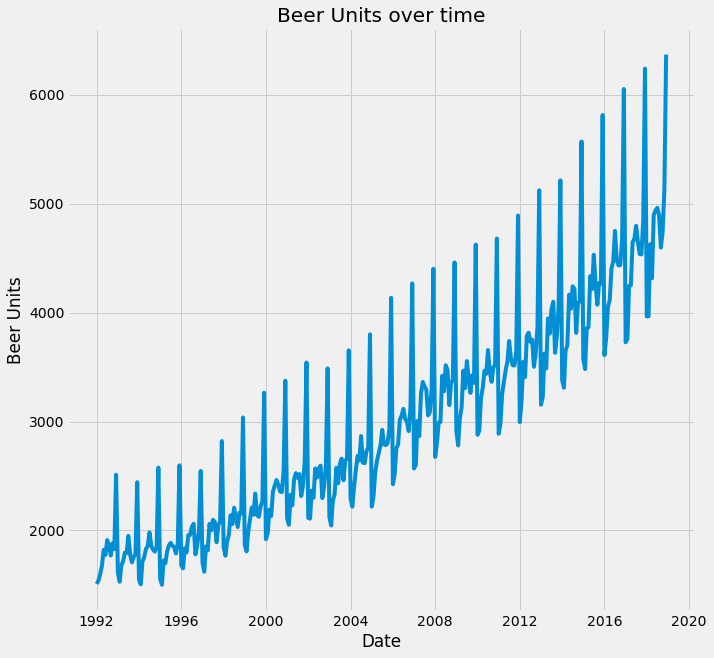

In [62]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,10))
plt.xlabel('Date')
plt.ylabel('Beer Units')
plt.title('Beer Units over time')
plt.plot(beer)
plt.show()

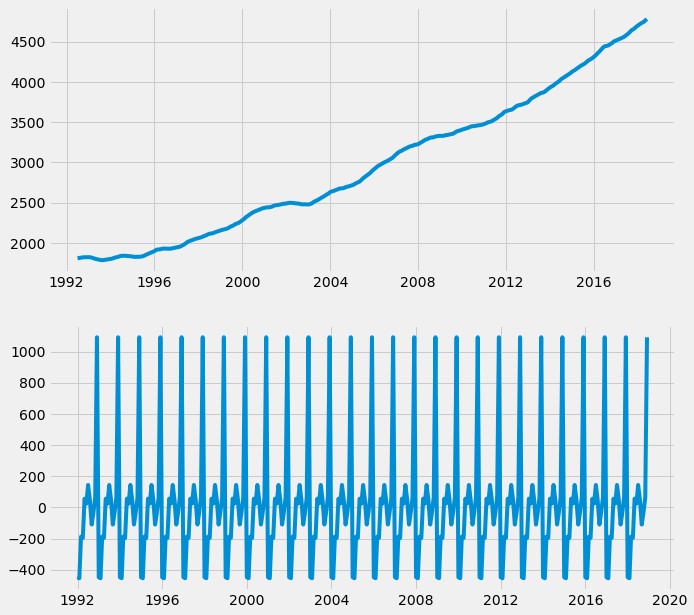

In [63]:
results=seasonal_decompose(beer)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(results.trend)
plt.subplot(2,1,2)
plt.plot(results.seasonal)
plt.show()

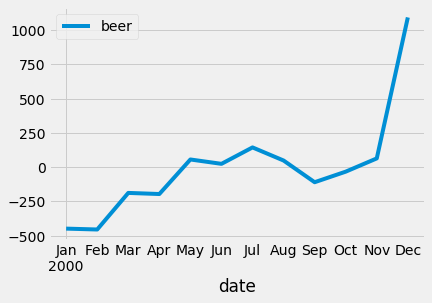

In [64]:
results.seasonal.loc['2000-01-01':'2000-12-31'].plot()
plt.show()

In [65]:
beer.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 324 entries, 1992-01-01 to 2018-12-01
Freq: MS
Data columns (total 1 columns):
beer    324 non-null int64
dtypes: int64(1)
memory usage: 15.1 KB


In [66]:
import warnings
warnings.filterwarnings("ignore")
result=auto_arima(beer,start_p=0,start_q=1,max_p=10,max_q=10,seasonal=False,error_action='ignore')

In [67]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  323
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -2408.071
Method:                       css-mle   S.D. of innovations            416.864
Date:                Sat, 17 Sep 2022   AIC                           4822.141
Time:                        14:56:38   BIC                           4833.474
Sample:                             1   HQIC                          4826.665
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.9920      1.219      8.195      0.000       7.602      12.382
ma.L1.D.y     -0.9508      0.014    -66.299      0.000      -0.979      -0.923
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.0518           +0.0000j            1.0518            0.0000
-----------------------------------------------------------------------------
"""

### Fitting without seasonal component
* Using the first 300 months as training set
* Using the last 24 observations as the test set 

In [68]:
train=beer.iloc[:300]
test=beer.iloc[300:]

In [69]:
test.shape

(24, 1)

In [70]:
train.sample(5)

,beer
date,
2000-05-01,2357
2011-03-01,3249
2016-04-01,4114
2015-09-01,4073
2005-09-01,2784


In [71]:
model=ARIMA(train['beer'],order=(0,1,1))

In [72]:
results=model.fit()

In [73]:
start=len(train)
end=len(train)+len(test)-1

In [74]:
end

323

In [75]:
predictions_ARIMA=results.predict(start=start,end=end,typ='levels')

In [76]:
from sklearn.metrics import mean_absolute_error as mae

In [77]:
mae(test.beer,predictions_ARIMA)/test.beer.mean()

0.08571101190241902

In [78]:
test['preds_ARIMA']=predictions_ARIMA

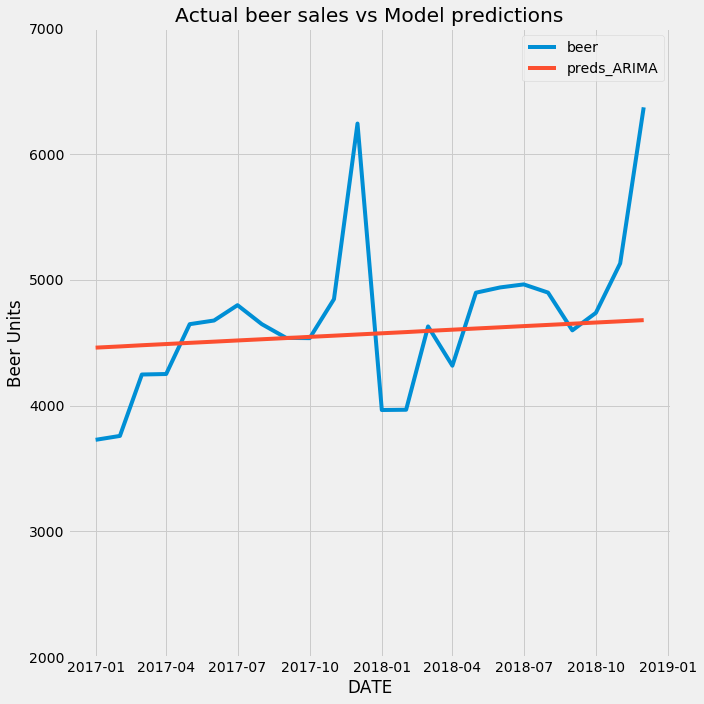

In [81]:
plt.figure(figsize=(10,10))
plt.plot(test)
plt.legend(test.columns)
plt.tight_layout()
plt.yticks([2000,3000,4000,5000,6000,7000])
plt.xlabel('DATE')
plt.ylabel('Beer Units')
plt.title('Actual beer sales vs Model predictions')
plt.tight_layout()
plt.savefig('ARIMA_test1')

### Adding in seasonal component

In [82]:
results=auto_arima(beer['beer'],start_p=0,start_q=1,max_p=10,max_q=10,max_P=10,seasonal=True,m=12)

In [83]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  324
Model:             SARIMAX(0, 1, 1)x(0, 0, 2, 12)   Log Likelihood               -2140.587
Date:                            Sat, 17 Sep 2022   AIC                           4291.174
Time:                                    14:59:40   BIC                           4310.062
Sample:                                         0   HQIC                          4298.714
                                            - 324                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      9.6809      1.882      5.144      0.000       5.992      13.370
ma.L1         -0.9483      0.020    -46.787      0.000      -0.988      -0.909
ma.S.L12       1.3419      0.045     29.676      0.000       1.253       1.431
ma.S.L24       0.6785      0.045     14.921      0.000       0.589       0.768
sigma2      3.059e+04   2033.054     15.044      0.000    2.66e+04    3.46e+04
===================================================================================
Ljung-Box (Q):                      425.56   Jarque-Bera (JB):               103.61
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.55   Skew:                             0.93
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [84]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [85]:
model=SARIMAX(train['beer'],order=(0,1,1),seasonal_order=(0,0,2,12))

In [86]:
results=model.fit()

In [87]:
predictions=results.predict(start=start,end=end,typ='levels')

In [88]:
(mae(test.beer,predictions)/test.beer.mean())*100

5.597297457272296

In [89]:
test['Peds_SARIMA']=predictions

In [90]:
test.columns=['Actuals','ARIMA_predictions','SARIMA_Predictions']

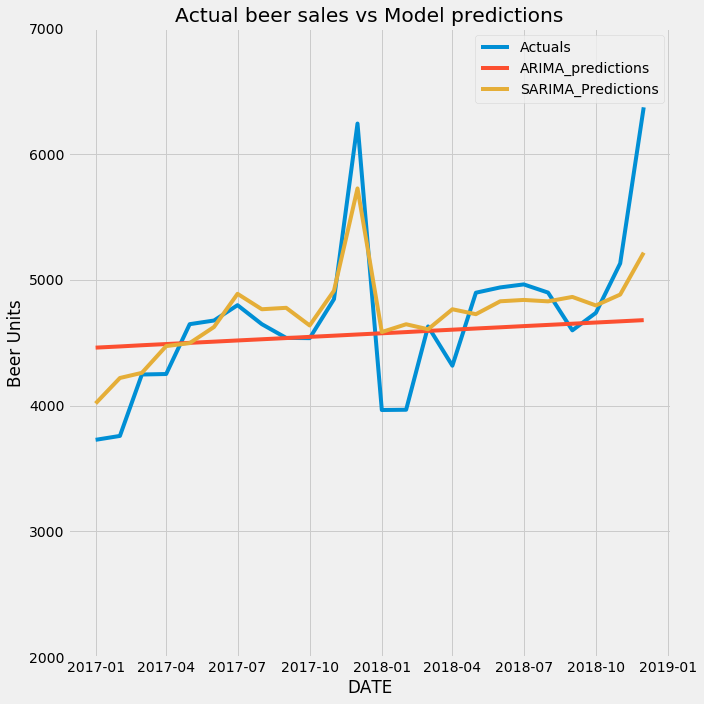

In [91]:
plt.figure(figsize=(10,10))
plt.plot(test)
plt.plot
plt.legend(test.columns)
plt.yticks([2000,3000,4000,5000,6000,7000])
plt.xlabel('DATE')
plt.ylabel('Beer Units')
plt.title('Actual beer sales vs Model predictions')
plt.tight_layout()
plt.savefig('ARIMA_test2')

In [92]:
model=SARIMAX(beer['beer'],order=(0,1,1),seasonal_order=(0,0,2,12))
results=model.fit()

In [93]:
fcast=results.predict(start='2019-01-01',end='2020-01-01',typ='levels')

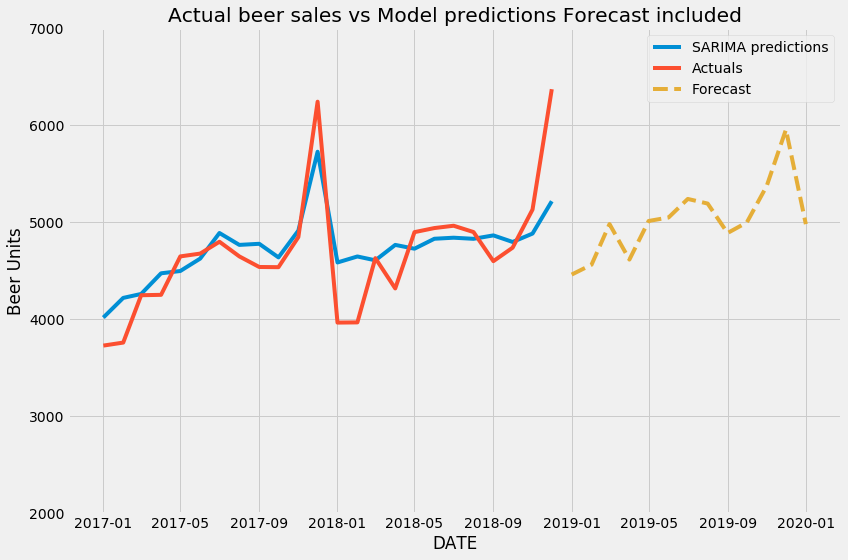

In [95]:
plt.figure(figsize=(12,8))
plt.plot(test.SARIMA_Predictions,label='SARIMA predictions')
plt.plot(test.Actuals,label='Actuals')
plt.plot(fcast,ls='--',label='Forecast')
plt.yticks([2000,3000,4000,5000,6000,7000])
plt.title('Actual beer sales vs Model predictions Forecast included')
plt.ylabel('Beer Units')
plt.xlabel('DATE')
plt.tight_layout()
plt.legend()
plt.savefig('ARIMA_test3')